# Probabilistic Matrix Factorization and Collaborative Filtering

Suppose we are given a dataset of ratings $M_{u_i, v_j}$, where $N_u$ users $u_1,...,u_{N_u}$ rate $N_2$ objects $v_1,..., v_{N_v}$ (say, movies). The problem is that there might be many entries of the matrix $(M_{i, j})_{i=1,...,N_u, j=1,...,N_v}$ that are not measured. Probabilistic Matrix Factorization is a way to approximate the missing values.

We fix $d \in \mathbb{N}$, $\lambda > 0$ and generate

$$ u_i \sim N(0, \lambda^{-1}), \;\;\;\;\;\;\; v_j \sim N(0, \lambda^{-1}), $$

where $I$ is the identity matrix on $\mathbb{R}^d$, for $i=1,...,N_u$ and $j=1,...,N_v$. We also fix $\sigma > 0$ and model

$$ M_{i, j} \sim N(u_i^T v_j, \sigma^2). $$

The point is that we gradually improve the choices of $u_i, v_j$. Let $\Omega$ be the set of pairs $(i, j)$ such that $M_{i,j}$ is measured. Writing out the log likelihood without constant terms (for details, see the paper https://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf), we want to maximize the objective function:

$$- \frac{1}{2\sigma^2}\sum_{(i, j) \in \Omega}\| M_{i,j} - u_i^T v_j\|^2 
- \frac{\lambda}{2}\sum_{i=1}^{N_u} \|u_i\|^2 
- \frac{\lambda}{2}\sum_{j=1}^{N_v} \|v_j\|^2.$$

Let $\Omega_{v_j}$ be the set of indices $i$ such that $(i, v_j)$ is measured; define $\Omega_{u_i}$ analogously. Using coordinate ascent, the algorithm consists of two steps:

1. Taking derivative in $u_i$'s, the choice of $u_i$'s that maximizes the objective function for fixed $v_j$'s is:
$$ u_i = \left(\lambda \sigma^2 + \sum_{j \in \Omega_{u_i}} v_j v_j^T \right)^{-1} 
\sum_{j \in \Omega_{u_i}} M_{i,j} v_j, $$
2. Symmetrically for fixed $u_i$'s the optimal choice of $v_j$'s is
$$ v_j = \left(\lambda \sigma^2 + \sum_{i \in \Omega_{v_j}} u_i u_i^T \right)^{-1} 
\sum_{i \in \Omega_{v_j}} M_{i,j} u_i. $$

We initially generate $v_j$'s from the normal distribution as described above and run the algorithm several times. Each time, first improving $u_i$'s with fixed $v_j$'s and then improving $v_j$'s, given $u_i$'s from the previous step.

## Application: MovieLens dataset

In the following we implement and apply the Probabilistic Matrix Factorization algorithm to MovieLens small dataset that can be found at: https://grouplens.org/datasets/movielens/ .

Import and load data:

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

data = np.genfromtxt('ratings.csv', delimiter=",")

# not using timestamp
X = np.delete(data[1:], 3, axis=1)
print(X.shape)
print(X)
print(np.amax(X[:, 1]))
print('max min rating: ', np.amax(X[:, 2]), np.amin(X[:, 2]))

(100004, 3)
[[  1.00000000e+00   3.10000000e+01   2.50000000e+00]
 [  1.00000000e+00   1.02900000e+03   3.00000000e+00]
 [  1.00000000e+00   1.06100000e+03   3.00000000e+00]
 ..., 
 [  6.71000000e+02   6.36500000e+03   4.00000000e+00]
 [  6.71000000e+02   6.38500000e+03   2.50000000e+00]
 [  6.71000000e+02   6.56500000e+03   3.50000000e+00]]
163949.0
max min rating:  5.0 0.5


There are three columns, in the first one there are user ids: these are numbers between 1 and 671. In the second one is movie ids: these are numbers between 1 and 163949. In the third one there are ratings: from 0.5 to 5.0 with a gap of 0.5, which makes it 10 possible outcomes in total. Note that originally there was one more column that was timestamp. I excluded it, since we are not going to make use of it here.

We need to do some data preprocessing in order to map the movie ids on the smallest possible range(there are plenty of gaps):

In [2]:
sort_objects = np.unique(X[:, 1])
sort_users = np.unique(X[:, 0])

for i in range(X.shape[0]):
    X[i, 0] = np.where(sort_users == int(X[i, 0]))[0][0]
    X[i, 1] = np.where(sort_objects == int(X[i, 1]))[0][0]

print(X.shape)
print(X)
# user and object max ids
user_max = int(np.amax(X[:, 0]))  # user max index
object_max = int(np.amax(X[:, 1]))  # object max index
print('Max user id: ', user_max)
print('Max movie id: ', object_max)

(100004, 3)
[[  0.00000000e+00   3.00000000e+01   2.50000000e+00]
 [  0.00000000e+00   8.33000000e+02   3.00000000e+00]
 [  0.00000000e+00   8.59000000e+02   3.00000000e+00]
 ..., 
 [  6.70000000e+02   4.59700000e+03   4.00000000e+00]
 [  6.70000000e+02   4.61000000e+03   2.50000000e+00]
 [  6.70000000e+02   4.69600000e+03   3.50000000e+00]]
Max user id:  670
Max movie id:  9065


Now movie id varies from 0 to 9065 and user id varies from 0 to 670.

We randomly shuffle the data and split it into training, validation and test sets:

In [3]:
#shuffling data
np.random.shuffle(X)
print(X)
print(X.shape)

#setting train, val, test sets
X_train = X[:60000]
X_val = X[60000:80000]
X_test = X[80000:]
print(X_train.shape, X_val.shape, X_test.shape)

[[  1.80000000e+01   7.86000000e+02   5.00000000e+00]
 [  5.79000000e+02   1.36700000e+03   4.00000000e+00]
 [  2.44000000e+02   3.42000000e+03   5.00000000e+00]
 ..., 
 [  6.23000000e+02   3.88200000e+03   4.00000000e+00]
 [  6.46000000e+02   1.59000000e+03   2.00000000e+00]
 [  1.64000000e+02   5.20000000e+02   3.00000000e+00]]
(100004, 3)
(60000, 3) (20000, 3) (20004, 3)


We will need a helper function for checking the average error (in the sense of $\ell^1$ norm).

In [4]:
def check_error(X, u, v):

    err = 0
    N = X.shape[0]
    for k in range(N):
        user_id = int(X[k, 0])
        object_id = int(X[k, 1])
        rating = int(X[k, 2])
        predict_rating = np.dot(u[user_id, :], v[object_id, :])
        err += np.absolute(predict_rating - rating)

    av_err = err / float(N)
    print('Average error: ', av_err)

    return av_err

Here is an implementation of the algorithm:

In [5]:
def PMF(train_data, val_data, user_max_id, object_max_id, iterations=2, lam=2, sigma2=0.1, d=10):

    length = train_data.shape[0]
    mean = np.zeros(d)
    cov = (1/float(lam))*np.identity(d)
    L = np.zeros(iterations) #objective function
    Nu = user_max_id + 1 #user max index
    Nv = object_max_id + 1 #object max index
    Mes = np.zeros((Nu, Nv)) #measured
    M = np.zeros((Nu, Nv)) #matrix of ratings
    train_err_list = []
    val_err_list = []

    for k in range(length):
        i = int(train_data[k, 0]) 
        j = int(train_data[k, 1]) 
        Mes[i, j] = 1 #user ui rated movie vj
        M[i, j] = train_data[k, 2] #setting rating

    ##initialize locations and users
    u = np.zeros((iterations, Nu, d))
    v = np.zeros((iterations, Nv, d))
    v[0, :, :] = np.random.multivariate_normal(mean, cov, Nv) #initialize v as multivariate normal

    for k in range(iterations):
        print('Iteration: ', k+1, ' / ', iterations)

        ##update user location
        if k == 0:
            l = 0
        else:
            l = k-1

        for i in range(Nu):
            A = lam * sigma2 * np.identity(d)
            vec = np.zeros(d)
            for j in range(Nv):
                if Mes[i, j] == 1:
                    A += np.outer(v[l, j, :], v[l, j, :])
                    vec += M[i, j]*v[l, j, :]
            u[k, i, :] = np.dot(np.linalg.inv(A), vec)

        ##update object location
        for j in range(Nv):
            A = lam * sigma2 * np.identity(d)
            vec = np.zeros(d)
            for i in range(Nu):
                if Mes[i, j] == 1:
                    A += np.outer(u[k, i, :], u[k, i, :])
                    vec += M[i, j]*u[k, i, :]
            v[k, j, :] = np.dot(np.linalg.inv(A), vec)

        ##update objective function
        for i in range(Nu):
            for j in range(Nv):
                if Mes[i, j] == 1:
                    L[k] -= np.square(M[i, j] - np.dot(u[k, i, :].T, v[k, j, :]))
        L[k] = (1/(2*sigma2))*L[k]
        L[k] -= (lam/float(2))*(np.square(np.linalg.norm(u[k, :, :])) + np.square(np.linalg.norm(v[k, :, :])))
        print('Loss: ', L[k])

        print('Training set:')
        train_err_list.append(check_error(train_data, u[k, :, :], v[k, :, :]))
        print('Validation set:')
        val_err_list.append(check_error(val_data, u[k, :, :], v[k, :, :]))

    return L, u, v, train_err_list, val_err_list

Finally, we run the algorithm, iterating over different choices of the hyperparameters and saving the best choice. One could of course also try different choices of d, however here we set d=10 and keep it fixed. It might take a while.

In [6]:
iterations = 10
count = 10
best_lam = -1
best_sigma2 = -1
best_av_err_val = 100
best_train_err_list = None
best_val_err_list = None

for i in range(count):
    print('Parameter iteration: ', i+1, ' / ', count)
    lam = 10**np.random.uniform(-0.5, 1.5)
    sigma2 = 10**np.random.uniform(-1.5, 0.5)
    print('lam:',lam, ' sigma2:', sigma2)
    L, u_matrices, v_matrices, train_err_list, val_err_list =\
    PMF(X_train, X_val, user_max, object_max, iterations, lam, sigma2, d=10)
    u = u_matrices[iterations-1, :, :]
    v = v_matrices[iterations-1, :, :]
    correct_train = 0

    # append training set error

    av_err_train = train_err_list[iterations-1]

    # append validation set error

    av_err_val = val_err_list[iterations-1]

    if av_err_val < best_av_err_val:
        best_av_err_val = av_err_val
        best_lam = lam
        best_sigma2 = sigma2
        best_train_err_list = train_err_list
        best_val_err_list = val_err_list

Parameter iteration:  1  /  10
lam: 3.3274399470315  sigma2: 0.9147095927476878
Iteration:  1  /  10
Loss:  -215585.985727
Training set:
Average error:  1.77134736206
Validation set:
Average error:  2.47114924034
Iteration:  2  /  10
Loss:  -64601.9168097
Training set:
Average error:  0.687498458822
Validation set:
Average error:  1.10178642314
Iteration:  3  /  10
Loss:  -52061.8039938
Training set:
Average error:  0.574548279962
Validation set:
Average error:  1.10661351096
Iteration:  4  /  10
Loss:  -46385.3104277
Training set:
Average error:  0.528706291261
Validation set:
Average error:  1.12143903358
Iteration:  5  /  10
Loss:  -42992.5271768
Training set:
Average error:  0.505139662612
Validation set:
Average error:  1.12311516768
Iteration:  6  /  10
Loss:  -40678.5298205
Training set:
Average error:  0.490975367605
Validation set:
Average error:  1.1158578647
Iteration:  7  /  10
Loss:  -38995.4446851
Training set:
Average error:  0.481446737729
Validation set:
Average error:

Average error:  1.06477825907
Iteration:  9  /  10
Loss:  -38104.3381171
Training set:
Average error:  0.811533708154
Validation set:
Average error:  1.06128211799
Iteration:  10  /  10
Loss:  -38085.7467501
Training set:
Average error:  0.810362703198
Validation set:
Average error:  1.05907708132
Parameter iteration:  7  /  10
lam: 1.1495228834127127  sigma2: 0.8460508594858761
Iteration:  1  /  10
Loss:  -235439.263424
Training set:
Average error:  1.84753917923
Validation set:
Average error:  2.72163415187
Iteration:  2  /  10
Loss:  -56322.4439644
Training set:
Average error:  0.6562574593
Validation set:
Average error:  1.11999008187
Iteration:  3  /  10
Loss:  -42292.7401383
Training set:
Average error:  0.526765050244
Validation set:
Average error:  1.10298472226
Iteration:  4  /  10
Loss:  -36175.2084765
Training set:
Average error:  0.47737199384
Validation set:
Average error:  1.13672461398
Iteration:  5  /  10
Loss:  -32543.1717671
Training set:
Average error:  0.45199962542

Now, for best_lambda and best_sigma2, train for more iterations:

In [7]:
iterations = 20
print('best_lam:', best_lam, ' best_sigma2:', best_sigma2)
print('Best validation set error: ', best_av_err_val)
L, u_matrices, v_matrices, train_err_list, val_err_list =\
PMF(X_train, X_val, user_max, object_max, iterations, best_lam, best_sigma2, d=10)

best_lam: 3.3708092679698183  best_sigma2: 2.7858697080308157
Best validation set error:  0.982862923173
Iteration:  1  /  20
Loss:  -93959.2842276
Training set:
Average error:  2.16606069776
Validation set:
Average error:  2.53663204086
Iteration:  2  /  20
Loss:  -36712.5567687
Training set:
Average error:  0.898904708937
Validation set:
Average error:  1.25302533754
Iteration:  3  /  20
Loss:  -29886.63259
Training set:
Average error:  0.754018264233
Validation set:
Average error:  1.13778969929
Iteration:  4  /  20
Loss:  -27221.3962113
Training set:
Average error:  0.690953027031
Validation set:
Average error:  1.07695875509
Iteration:  5  /  20
Loss:  -26078.8276566
Training set:
Average error:  0.658837505071
Validation set:
Average error:  1.03879687753
Iteration:  6  /  20
Loss:  -25556.2004873
Training set:
Average error:  0.641585945574
Validation set:
Average error:  1.0151110295
Iteration:  7  /  20
Loss:  -25301.5265972
Training set:
Average error:  0.631684384892
Validat

Let us view the training loss (note that we change its sign to have positive value) and error on training and validation set.

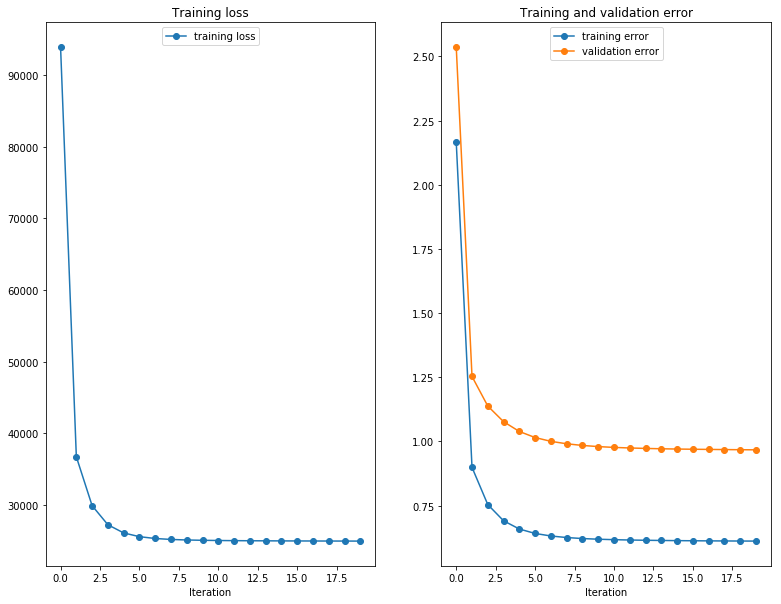

In [8]:
L = -L
plt.subplot(1, 2, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.plot(L, '-o', label='training loss')

plt.subplot(1, 2, 2)
plt.title('Training and validation error')
plt.xlabel('Iteration')
plt.plot(train_err_list, '-o', label='training error')
plt.plot(val_err_list, '-o', label='validation error')
plt.legend(loc='upper center')

plt.subplot(1, 2, 1)
plt.legend(loc='upper center')

plt.subplot(1, 2, 2)
plt.legend(loc='upper center')

plt.gcf().set_size_inches(13, 10)
plt.show()

Finally, we test performance on the test set.

In [9]:
u = u_matrices[iterations-1, :, :]
v = v_matrices[iterations-1, :, :]
print('Test set: ')
_ = check_error(X_test, u, v)

Test set: 
Average error:  0.962230022385
